In [1]:
!pip install -q fastbook

In [2]:
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from fastbook import *
from pathlib import Path
import os

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor() 
])

In [4]:
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:10<00:00, 16392477.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


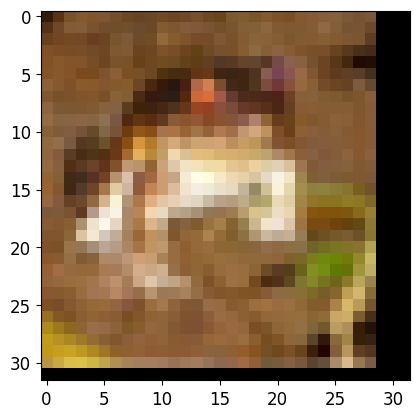

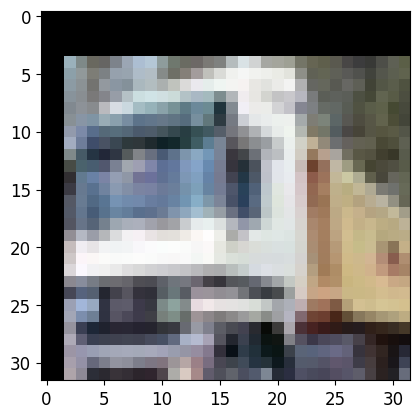

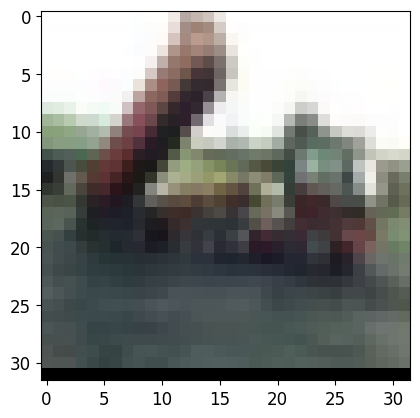

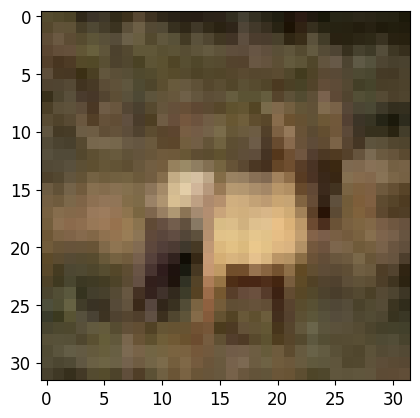

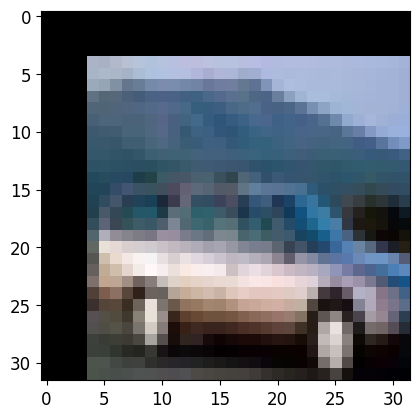

In [5]:
epochs=5
for epoch in range(epochs):
  img, label= trainset[epoch]
  img= torch.permute(img, (1,2,0))
  plt.imshow(img.numpy())
  plt.show()

In [6]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class CIFAR10Model(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape),
            nn.Dropout(0.5)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model0 = CIFAR10Model(input_shape=3,
    hidden_units=256,
    output_shape=len(classes)).to(device)

model0

CIFAR10Model(
  (block_1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fe

In [8]:
def training(model, loss_fn, optimizer, train_loader):
  trainLoss = 0
  model.train()
  for imgs ,labels in train_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    train_pred=model(imgs)
    loss= loss_fn(train_pred,labels)
    trainLoss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  scheduler.step()
  trainLoss=trainLoss/len(trainloader)

  return trainLoss


In [9]:
def test(model, loss_fn , test_loader):
  testLoss=0
  total_acc=0
  model.eval()
  for imgs ,labels in test_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    test_pred=model(imgs)
    loss= loss_fn(test_pred,labels)
    testLoss+=loss.item()
    acc=accuracy(test_pred,labels)
    total_acc+=acc
  total_acc=total_acc/len(test_loader)
  testLoss=testLoss/len(testloader)
  return testLoss, total_acc


In [10]:
def accuracy(pred,target):
  correct_count=0
  total_count = len(target)
  tensor=torch.eq(pred.argmax(dim=1), target)
  for t in tensor:
    if t ==True:
      correct_count+=1
  acc=(correct_count/total_count)*100
  return acc


In [11]:
epochs=30
model=model0
loss_fn=nn.CrossEntropyLoss()
params=model0.parameters()
lr=0.15
optimizer=torch.optim.SGD(params=params, lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_loader=trainloader
test_loader=testloader

for epoch in range(epochs):
    
  trainLoss= training(model, loss_fn, optimizer, train_loader)

  with torch.inference_mode():
    testLoss, total_acc = test(model, loss_fn, test_loader)
    if epoch%3==0:
      print(f"Epoch {epoch}/{epochs}, Train Loss: {trainLoss:.2f}, Test Loss: {testLoss:.2f}-----accuracy: {total_acc:.2f}%")



Epoch 0/30, Train Loss: 2.21, Test Loss: 1.83-----accuracy: 34.40%
Epoch 3/30, Train Loss: 1.72, Test Loss: 1.28-----accuracy: 58.30%
Epoch 6/30, Train Loss: 1.55, Test Loss: 0.96-----accuracy: 70.67%
Epoch 9/30, Train Loss: 1.48, Test Loss: 0.91-----accuracy: 70.93%
Epoch 12/30, Train Loss: 1.31, Test Loss: 0.63-----accuracy: 80.54%
Epoch 15/30, Train Loss: 1.28, Test Loss: 0.60-----accuracy: 81.39%
Epoch 18/30, Train Loss: 1.26, Test Loss: 0.58-----accuracy: 82.28%
Epoch 21/30, Train Loss: 1.23, Test Loss: 0.55-----accuracy: 82.94%
Epoch 24/30, Train Loss: 1.23, Test Loss: 0.55-----accuracy: 83.04%
Epoch 27/30, Train Loss: 1.22, Test Loss: 0.55-----accuracy: 83.20%


In [12]:
torch.save(model0.state_dict(), 'model_weights.pth')
model0.load_state_dict(torch.load('/kaggle/working/model_weights.pth'))
model0.eval()

CIFAR10Model(
  (block_1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_fe

In [13]:
for query in classes:
  path=Path(f"./images/{query}")
  if not path.exists():
    path.mkdir(parents=True, exist_ok=True)

  urls = search_images_ddg(query, max_images=5)
  print(urls)
  for url in urls:
    try:
        download_url(dest=path, url=url)
        break
    except:
        one_url = search_images_ddg(query, max_images=1)
        try:
            download_url(dest=path, url=one_url[0])
        except:
            one_url = search_images_ddg(query, max_images=1)
            download_url(dest=path, url=one_url[0])

['https://www.rd.com/wp-content/uploads/2019/08/shutterstock_552420106-scaled.jpg?w=2560', 'http://www.wallpaperbetter.com/wallpaper/498/137/202/passenger-plane-flying-on-clouds-top-2K-wallpaper.jpg', 'http://timoelliott.com/personal/wp-content/uploads/2009/12/plane-on-runway.jpg', 'http://pngimg.com/uploads/plane/plane_PNG101210.png', 'https://g.foolcdn.com/editorial/images/211721/f-16.jpg']


['https://www.isharearena.com/wp-content/uploads/2012/11/wallpaper-1294864.jpg', 'https://c.wallhere.com/photos/98/8d/car_supercars_vehicle_Lamborghini_black_cars_reflection_simple_background-1624153.jpg!d', 'http://2.bp.blogspot.com/-RfL0lQVujUw/VOifTc8Pv1I/AAAAAAAAAlg/zy9WVZN53MI/s1600/car%2Bwallpapers1.jpg', 'https://wallpapercave.com/wp/wp9040436.jpg', 'https://assets.flatpyramid.com/wp-content/uploads/uploads/3d-models/images/vehicles_3d_models/generic-sports-car-3d-model-160515.jpg']


['http://www.yourpictureframes.com/blog/wp-content/uploads/2010/02/Blue-Bird.jpg', 'https://opticsmag.com/wp-content/uploads/2021/04/american-goldfinch_Miles-Moody_Pixabay-768x512.jpg', 'https://qph.fs.quoracdn.net/main-qimg-d5ef14a6733e4a0ff207c4c26db52341-c', 'https://i.pinimg.com/originals/12/c7/4b/12c74b69e27265b80536cc47d374270e.jpg', 'https://i.pinimg.com/originals/59/f0/00/59f000ed08d5a4280e01085d5b119ad4.jpg']


['https://i.pinimg.com/originals/b5/14/49/b51449210e2916eb89c612adb11b3bfc.jpg', 'https://assets.rbl.ms/9570694/980x.jpg', 'https://i.pinimg.com/originals/1b/57/dd/1b57ddaa0cd584e21023d3d00ea50db4.jpg', 'https://i.pinimg.com/originals/29/f1/de/29f1de09a1284f16085f54c8325267c0.jpg', 'https://cat-world.com/wp-content/uploads/2022/09/Orange-Tabby-Cats-Fat.jpg']


['http://wallsdesk.com/wp-content/uploads/2017/01/Pictures-of-Deer-.jpg', 'https://insider.si.edu/wp-content/uploads/2017/10/deer2-1.jpg', 'https://randyroberts.files.wordpress.com/2009/06/img_1814a.jpg', 'http://cdn.wallpapersafari.com/49/58/GBtjQk.jpg', 'http://www.natezeman.com/images/xl/0683_NZ_Red_Hart_WM.jpg']


['https://paradepets.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTkxMzY1Nzg4NjczMzIwNTQ2/cutest-dog-breeds-jpg.jpg', 'http://www.spockthedog.com/wp-content/uploads/2013/08/Basset-Hound-Relaxing.jpg', 'https://cdn.wallpapersafari.com/2/13/gnmV0j.jpg', 'https://coolwallpapers.me/picsup/3314785-dachshund-dog-muzzle-ears-waiting.jpg', 'https://housing.com/news/wp-content/uploads/2023/07/Cute-dog-breeds-that-make-the-best-pets-f-686x400.jpg']


['http://upload.wikimedia.org/wikipedia/commons/c/c4/Jumping_frog.jpg', 'https://images3.alphacoders.com/173/173849.jpg', 'https://i.pinimg.com/originals/bf/99/b9/bf99b9e11ccdc5ad2e44b0887f65a8a1.jpg', 'http://www.worldsciencefestival.com.au/wp-content/uploads/2017/11/Roth_s-Tree-Frog-Litoria-rothii-Photo-by-Jodi-RowleyB.jpg', 'https://images8.alphacoders.com/602/602798.jpg']


['https://www.helpfulhorsehints.com/wp-content/uploads/dapple-palomino-horse-9-1.jpg', 'https://i.ytimg.com/vi/GrKrvLW4hvU/maxresdefault.jpg', 'https://horsesandfoals.com/wp-content/uploads/2019/07/mammal-3330882_1280-1.jpg', 'https://i.pinimg.com/originals/db/77/a5/db77a5ab05c30bcaec744973c7b8f323.jpg', 'https://i.pinimg.com/originals/21/ee/79/21ee793e9e3a368f4aabe6815d1b7ce9.jpg']


['http://upload.wikimedia.org/wikipedia/commons/c/c1/Carnival-Freedom-Cruise-Ship.jpg', 'https://www.cruisehive.com/wp-content/uploads/2015/03/virgin1.jpg', 'https://tallshipsnetwork.com/wp-content/uploads/2020/02/LaGrace-celek-vlevo.jpg', 'https://classicyachtbrokerage.co.uk/wp-content/uploads/2021/04/STS-Lord-Nelson16.jpg', 'https://www.gannett-cdn.com/-mm-/c173f561ff6cae45ed6d0bd438728f9139d3db3c/c=0-38-1045-628/local/-/media/2017/05/09/USATODAY/USATODAY/636299266378082353-triumph--smaller-web.jpg?width=3200&height=1680&fit=crop']


['https://truckcolors.com/wp-content/uploads/2017/08/truck-colors.jpg', 'https://www.tecequipment.com/app/uploads/2020/10/Volvo-Semi-Truck.jpg', 'https://engineeringlearn.com/wp-content/uploads/2022/01/Trucks-2-1024x539.jpg', 'http://indonesian.mining-dumptruck.com/photo/pl21981490-red_color_howo_371_336_290_266hp_6x4_10_wheeler_dump_truck_dumper_tipper_truck.jpg', 'https://bringatrailer.com/wp-content/uploads/2018/09/1947_dodge_wd-15_12_ton_truck_1538090836cd20849DSC_0041.jpg']


bird
AxesImage(size=(32, 32))


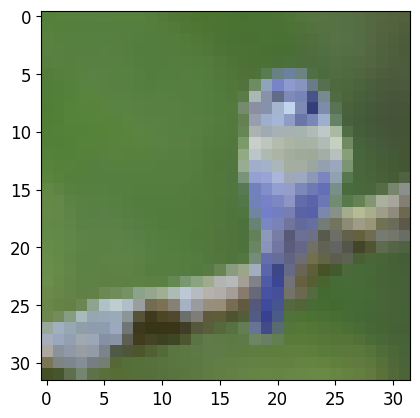

In [15]:
def one_example(path):
    image = Image.open(path)  
    image = test_transform(image)
    image=image.unsqueeze(0)
    image=image.to(device)
    outputs=model0(image)
    _, predicted = torch.max(input=outputs, dim=1)
    print(classes[predicted.item()])
    print(plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy()))

path="/kaggle/working/images/bird/Blue-Bird.jpg"
one_example(path)

In [17]:
'''def all_examples():
    folder="/kaggle/working/images"
    classes= os.listdir(folder)
    for c in classes:
        class_path = os.path.join(folder, c)
        list_imgs=os.listdir(class_path)
        for img in list_imgs:
            img_path=os.path.join(class_path,img)
            img = Image.open(img_path)
            image = test_transform(img)
            image=image.unsqueeze(0)
            image=image.to(device)
            outputs=model0(image)
            _, predicted = torch.max(input=outputs, dim=1)
            title=classes[predicted.item()]
            print(title)
            plt.figure()
            plt.title(title)
            plt.imshow(img)
            print(plt.show())
        
all_examples()'''

'def all_examples():\n    folder="/kaggle/working/images"\n    classes= os.listdir(folder)\n    for c in classes:\n        class_path = os.path.join(folder, c)\n        list_imgs=os.listdir(class_path)\n        for img in list_imgs:\n            img_path=os.path.join(class_path,img)\n            img = Image.open(img_path)\n            image = test_transform(img)\n            image=image.unsqueeze(0)\n            image=image.to(device)\n            outputs=model0(image)\n            _, predicted = torch.max(input=outputs, dim=1)\n            title=classes[predicted.item()]\n            print(title)\n            plt.figure()\n            plt.title(title)\n            plt.imshow(img)\n            print(plt.show())\n        \nall_examples()'